In [ ]:
./

In [505]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
import ast
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from scipy import stats

In [428]:
# Read in datasets
listing_se = pd.read_csv('listings.csv')
calendar_se = pd.read_csv('calendar.csv')
reviews_se = pd.read_csv('reviews.csv')
listing_lv = pd.read_csv('listings_lv.csv')
reviews_lv = pd.read_csv('reviews_lv.csv')

In [568]:
# check basic information 
reviews_lv.info()
listing_lv.city.unique()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177597 entries, 0 to 177596
Data columns (total 2 columns):
listing_id    177597 non-null int64
date          177597 non-null object
dtypes: int64(1), object(1)
memory usage: 2.7+ MB


# Three business questions to ask
- Q1: Do guests' review habits differ between Seattle and Las Vegas?
- Q2: What factors help a listing attract more reviews?
- Q3: Do superhosts get price premium in general?

In [594]:
def clean_data(listing, reviews):
    '''
    This function cleans a dataframe for it to be ready for listing-reviews study only
    Input: pass in a listing dataframe and a reviews dataframe from a region
    Output: clean dataframe with a pre-chosen features. Categorical variables are left for dummification later on.
    '''
    columns_rev = ['number_of_reviews', 'review_scores_rating',
                 'review_scores_value', 'host_response_rate', 
                 'host_is_superhost', 'neighborhood_overview', 'state', 
                 'is_location_exact', 'property_type', 'room_type', 
                 'accommodates', 'bathrooms', 'beds', 'price', 'host_has_profile_pic']
    # return a reduced dataframe
    red_listing = listing.loc[:, columns_rev]
    
    # To check if NaN is present at all in this dataframe. It is always better to check than to assume NaNs do or don't exist.
    if red_listing.isnull().values.any():
        #Percentage of missing data column-wise, Percentage of missing data row-wise
        col_miss = red_listing.isnull().sum()/red_listing.shape[0]
        row_miss = se_listing.isnull().sum(axis=1)/red_listing.shape[1]
        # return this tuple later
        
        
        # if a column has less than 20 missing data, remove the rows that contains them
        col_miss_20 = list(red_listing.isnull().sum()[red_listing.isnull().sum() <= 20].index)
        for c in col_miss_20:
            red_listing = red_listing[red_listing[c].notnull()]
        
        # DEBUGGING: return red_listing.isnull().sum()
        
        # Handle missing data - Categorical
        # recoding this column. I want to see the effect of a host having written an overview on guests' review response
        red_listing['neighborhood_overview'] = np.where(red_listing['neighborhood_overview'] != 0, 1, red_listing['neighborhood_overview'])
        
        # Handle missing data - Numeric
        imp_0 = Imputer(missing_values='NaN', strategy="most_frequent", axis=0)
        red_listing["review_scores_rating"] = imp_0.fit_transform(red_listing[["review_scores_rating"]]).ravel()
        
        # Debugging: return red_listing.isnull().sum()
        imp_1= Imputer(missing_values='NaN', strategy="median", axis=0)
        red_listing["review_scores_value"] = imp_1.fit_transform(red_listing[["review_scores_value"]]).ravel()
        
        red_listing["host_response_rate"] = red_listing["host_response_rate"].str.replace('%', '')
        red_listing["host_response_rate"] = red_listing["host_response_rate"].astype(float)
        imp_2= Imputer(missing_values='NaN', strategy="median", axis=0)
        red_listing["host_response_rate"] = imp_2.fit_transform(red_listing[["host_response_rate"]]).ravel()
        
       
        # Special handling on Price column with str characters mixed with numbers
        red_listing['price'] = red_listing['price'].str.strip('$')
        red_listing['price'] = red_listing['price'].astype(str)
        red_listing['price'] = red_listing['price'].str.replace('.', '')
        red_listing['price'] = red_listing['price'].str.replace(',', '')
        red_listing['price'] = red_listing['price'].astype('int')/100
        
        
        return red_listing

clean_lv_list = clean_data(listing_lv, reviews_lv)
clean_sea_list = clean_data(listing_se, reviews_se)

# Q1:Do people give more reviews when visiting Seattle?

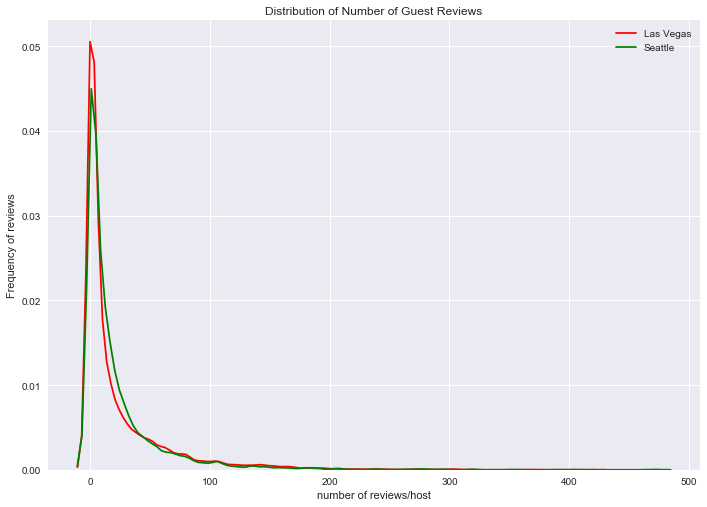

In [491]:
# seaborn histogram
# for df in [clean_lv_list, clean_sea_list]:
#     sns.distplot(df.number_of_reviews, 
#              hist=True, kde=False, norm_hist=True,
#              hist_kws={'edgecolor':'black'})

sns.set(rc={'figure.figsize':(11.7,8.27)})
fig, ax = plt.subplots(1,1)
s1 = sns.distplot(clean_lv_list.number_of_reviews, 
              hist=False, kde=True, color = 'red', norm_hist=True,
              label = 'Las Vegas')

s2 = sns.distplot(clean_sea_list.number_of_reviews, 
              hist=False, kde=True, color = 'green', norm_hist=True,
              label = 'Seattle')

# Add labels
plt.title('Distribution of Number of Guest Reviews')
plt.xlabel('number of reviews/host')
plt.ylabel('Frequency of reviews')
plt.legend()
plt.show()


In [595]:
# This cell is for checking some steps.
#clean_lv_list.number_of_reviews.value_counts()[0]/clean_lv_list.shape[0]
#clean_sea_list.number_of_reviews.value_counts()[0]/clean_sea_list.shape[0]
#clean_lv_list.number_of_reviews.mean() , clean_sea_list.number_of_reviews.mean()
#clean_lv_list.number_of_reviews.max() , clean_sea_list.number_of_reviews.max()
#clean_lv_list.number_of_reviews.min() , clean_sea_list.number_of_reviews.min()


# Q2: What factors help a listing attract more reviews?

In [606]:
# Machine supervised learning part.
# Dealing with Categorical Variables
sea_list = pd.get_dummies(clean_sea_list)
# split into train and test data.
sea_X = sea_list.drop(['number_of_reviews'], axis = 1)
sea_y = sea_list['number_of_reviews']
sea_X_train, sea_X_test, sea_y_train, sea_y_test = train_test_split(sea_X, sea_y, test_size = 0.20, random_state = 109)
lm_model = LinearRegression(normalize=False) # Instantiate
lm_model.fit(sea_X_train, sea_y_train) #Fit
lm_model = LinearRegression(normalize=False) # Instantiate
lm_model.fit(sea_X_train, sea_y_train) #Fit
        
#Predict and score the model. We only care about the signs of the coefficients.
#Need p-values for more technical analysis if necessary.
sea_y_test_preds = lm_model.predict(sea_X_test) 
"The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(sea_y_test, sea_y_test_preds), len(sea_y_test))

'The r-squared score for the model using only quantitative variables was 0.12564619031375746 on 760 values.'

In [607]:
lm_model.coef_
dict(zip(sea_X_test.columns, lm_model.coef_))

{'review_scores_rating': -0.3320504073371529,
 'review_scores_value': -2.7516939688746334,
 'host_response_rate': 0.14954158380179483,
 'accommodates': 2.2788475735661424,
 'bathrooms': -2.65182668985318,
 'beds': -2.7619997128154945,
 'price': -0.052312735894225,
 'host_is_superhost_f': -11.74609600950146,
 'host_is_superhost_t': 11.746096009503312,
 'neighborhood_overview_1': 0.0,
 'state_WA': 4.159050043051794,
 'state_wa': -4.159050043051769,
 'is_location_exact_f': -6.25339843812893,
 'is_location_exact_t': 6.2533984381289205,
 'property_type_Apartment': -3.7926459911713413,
 'property_type_Bed & Breakfast': -1.3130157689649222,
 'property_type_Boat': -9.361646670437624,
 'property_type_Bungalow': -14.04517990347697,
 'property_type_Cabin': 54.65605669992713,
 'property_type_Camper/RV': 22.436609512046246,
 'property_type_Chalet': -7.969794572431222,
 'property_type_Condominium': -13.377675836018472,
 'property_type_Dorm': 2.8731802003627376,
 'property_type_House': -3.16721377770

Text(0,0.5,'Number of Guest Reviews Seattle')

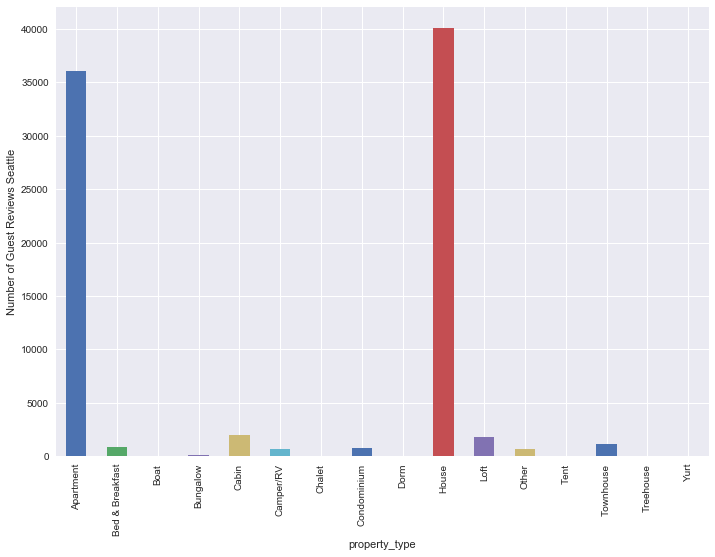

In [601]:
#clean_sea_list.head()
# Bar charts in Seattle grouped by property types.
grouped = clean_sea_list.groupby(['property_type'])['number_of_reviews']
ax = grouped.sum().plot(kind='bar')
ax.set_ylabel('Number of Guest Reviews Seattle')

Text(0,0.5,'Number of Guest Reviews Las Vegas')

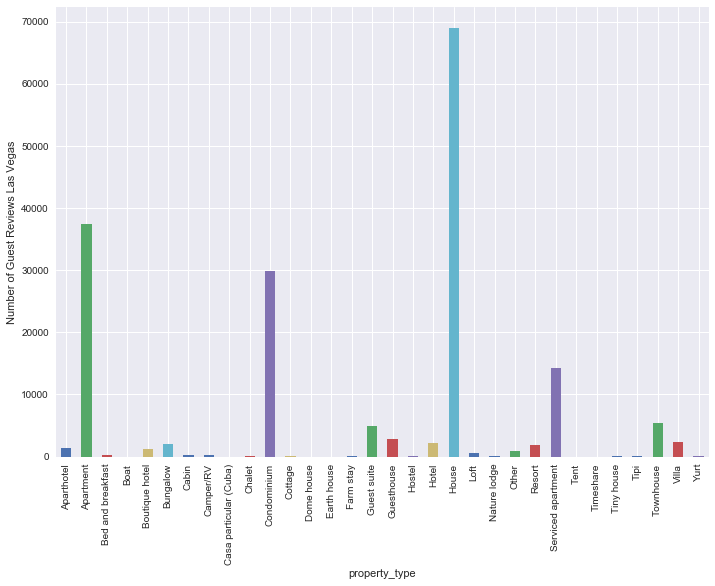

In [602]:
# Bar chart of Las Vegas listings' reviews by property type
grouped = clean_lv_list.groupby(['property_type'])['number_of_reviews']
ax = grouped.sum().plot(kind='bar')
ax.set_ylabel('Number of Guest Reviews Las Vegas')

Text(0,0.5,'Number of Guest Reviews Seattle')

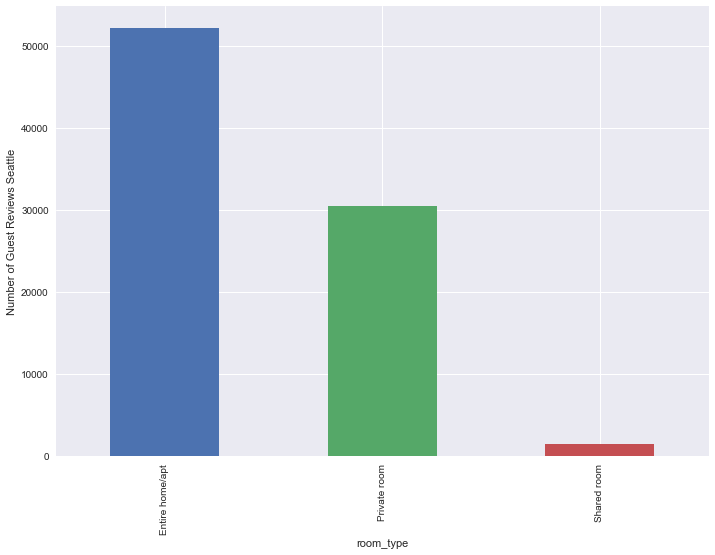

In [599]:
#Number of reviews in Seattle grouped by room type
grouped = clean_sea_list.groupby(['room_type'])['number_of_reviews']
ax = grouped.sum().plot(kind='bar')
ax.set_ylabel('Number of Guest Reviews Seattle')

# import matplotlib.ticker as mtick
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())

Text(0,0.5,'Number of Guest Reviews Las Vegas')

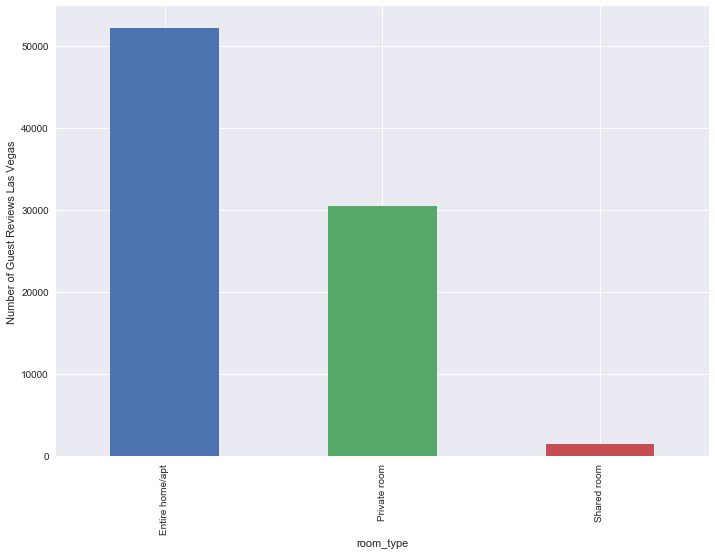

In [600]:
grouped = clean_sea_list.groupby(['room_type'])['number_of_reviews']
ax = grouped.sum().plot(kind='bar')
ax.set_ylabel('Number of Guest Reviews Las Vegas')

# Q3: Do Superhosts enjoy price premiums?

In [584]:
# I claimed there exists negative correlaton between price and number of reviews in the blog.
clean_lv_list['number_of_reviews'].corr(clean_lv_list['price'])
clean_sea_list['number_of_reviews'].corr(clean_sea_list['price'])

-0.12400334054681922

Text(0.5,1,'Las Vegas')

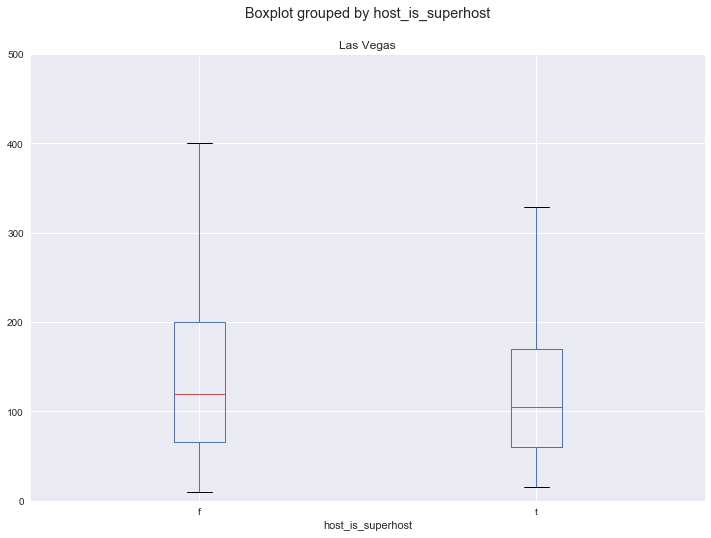

In [580]:
boxplot = clean_lv_list.boxplot(column=['price'], by='host_is_superhost',
                    layout=(1, 1))
plt.ylim(0,500)
plt.title('Las Vegas')

Text(0.5,1,'Seattle')

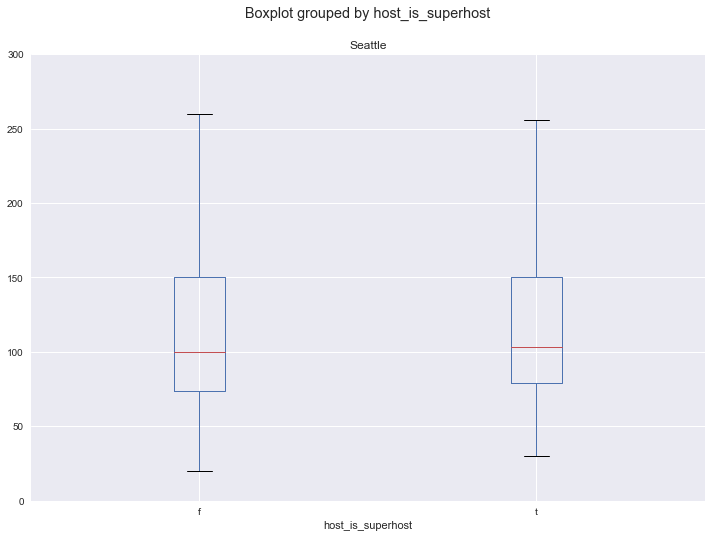

In [593]:
boxplot = clean_sea_list.boxplot(column=['price'], by='host_is_superhost',
                    layout=(1, 1))
plt.ylim(0,300)

plt.title('Seattle')

accommodates
1     AxesSubplot(0.125,0.125;0.775x0.755)
2     AxesSubplot(0.125,0.125;0.775x0.755)
3     AxesSubplot(0.125,0.125;0.775x0.755)
4     AxesSubplot(0.125,0.125;0.775x0.755)
5     AxesSubplot(0.125,0.125;0.775x0.755)
6     AxesSubplot(0.125,0.125;0.775x0.755)
7     AxesSubplot(0.125,0.125;0.775x0.755)
8     AxesSubplot(0.125,0.125;0.775x0.755)
9     AxesSubplot(0.125,0.125;0.775x0.755)
10    AxesSubplot(0.125,0.125;0.775x0.755)
11    AxesSubplot(0.125,0.125;0.775x0.755)
12    AxesSubplot(0.125,0.125;0.775x0.755)
14    AxesSubplot(0.125,0.125;0.775x0.755)
15    AxesSubplot(0.125,0.125;0.775x0.755)
16    AxesSubplot(0.125,0.125;0.775x0.755)
Name: number_of_reviews, dtype: object

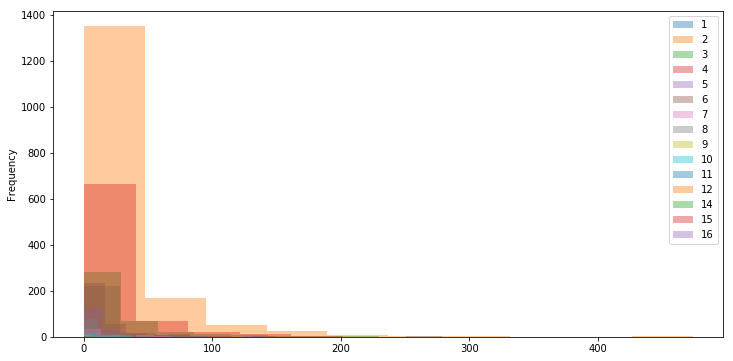

In [407]:
# Alternative question I am exploring. Didn't make it to the post.
# Safely ignore everything from here.
sea_list.accommodates = sea_list.accommodates.astype(int)
#sea_list.number_of_reviews.plot(kind="hist", by = 'accommodates')
group_sea = sea_list.groupby('accommodates')
group_sea.number_of_reviews.plot(kind='hist', figsize=[12,6], alpha=.4, legend = True) # alpha for transparency
    
#sea_list['number_of_reviews'].hist(by=sea_list['accommodates'])
# fig, ax = plt.subplots(figsize=(8,6))
# for label, df in sea_list.groupby('accommodates'):
#     sea_list.number_of_reviews.plot(kind="hist", ax=ax, label=label)
#     ax.set_xlim(0, 400)
# plt.legend()

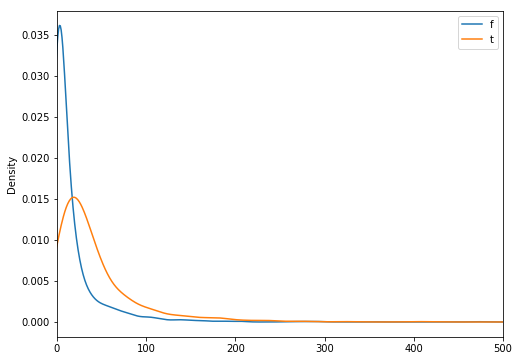

In [388]:
fig, ax = plt.subplots(figsize=(8,6))
for label, df in explore_rev.groupby('host_is_superhost'):
    df.number_of_reviews.plot(kind="density", ax=ax, label=label)
    ax.set_xlim(0, 500)
plt.legend()

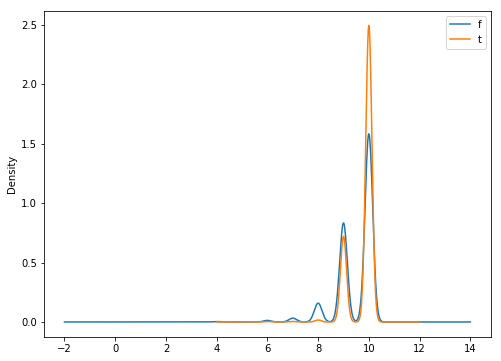

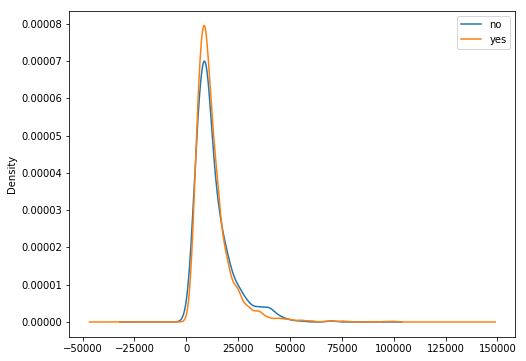

In [261]:
#TODO
#Review trends and price differences among reviewed listings boxplot
# categorize houses reviews into two different categories.

This suggests that price is not the factor that makes people don't want to leave reviews. 
What matters is if the host is a super host or not?
Super hosts' houses do get more reviews. Is this fair though? Maybe the volumn of reviews before a person becomes a superhost is a crucial factor contributes to this host becoming a super host.

#TODO
https://medium.com/@reneeshiyanliu/a-naive-sleuth-on-airbnbs-cheapest-secret-weapon-user-reviews-d04f8d43555b

In [ ]:
#TODO
# Actions:
# How to help bunglows/tents owners to get more reviews? Maybe by providing wifis?
# Another economic question to ask is what is the monetized value of revews? Should reviewers be getting financial incentives?
#TODO
#clean_data function to transform las vegas data